In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install scikit-surprise
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data 
# Load the dataset (after unzipping ml-latest-small.zip)
# Load Data 
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
# Data Overview
print("\nData Overview:")
print(f"Movies: {movies.shape[0]} records")
print(f"Ratings: {ratings.shape[0]} records")
print("\nSample Movies:")
print(movies.head())
print("\nSample Ratings:")
print(ratings.head())


Data Overview:
Movies: 9742 records
Ratings: 100836 records

Sample Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Sample Ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


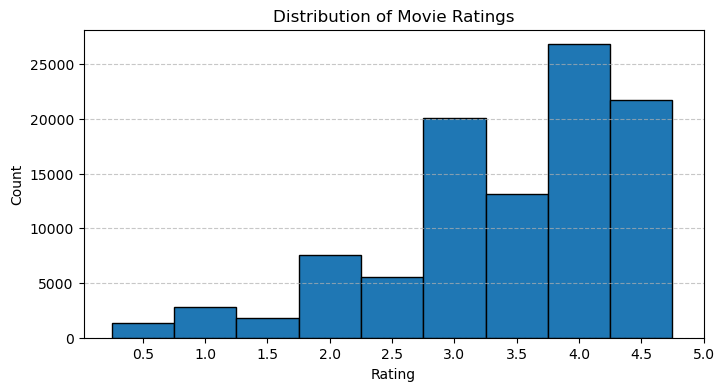

In [4]:
plt.figure(figsize=(8,4))
bins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0]
plt.hist(ratings['rating'], bins=bins, edgecolor='black', align='left')
plt.xticks(bins)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
# Preprocessing
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else x)
genre_expanded = movies.explode('genres')
genre_dummies = pd.get_dummies(genre_expanded['genres']).groupby(genre_expanded['movieId']).max()

movies = pd.merge(movies, genre_dummies, left_on='movieId', right_index=True)
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

user_item_matrix = ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [6]:
# Content-Based Recommendations

tfidf = TfidfVectorizer(stop_words='english')
title_matrix = tfidf.fit_transform(movies['title'])
title_similarity = cosine_similarity(title_matrix)

# use toy story as an example
try:
    toy_story_idx = movies[movies['title'].str.contains("Toy Story", case=False)].index[0]
    sim_scores = list(enumerate(title_similarity[toy_story_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:6]]
    content_recs = movies.iloc[sim_indices][['movieId', 'title', 'genres']]
    
    print("\nContent-based recommendations similar to 'Toy Story':")
    print(content_recs)
except IndexError:
    print("Movie not found")


Content-based recommendations similar to 'Toy Story':
      movieId                title  \
2355     3114   Toy Story 2 (1999)   
7355    78499   Toy Story 3 (2010)   
3595     4929      Toy, The (1982)   
4089     5843  Toy Soldiers (1991)   
26         27  Now and Then (1995)   

                                                 genres  
2355  [Adventure, Animation, Children, Comedy, Fantasy]  
7355  [Adventure, Animation, Children, Comedy, Fanta...  
3595                                           [Comedy]  
4089                                    [Action, Drama]  
26                                    [Children, Drama]  


In [7]:
# Collaborative Filtering Setup
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)
# KNN
knn = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
knn.fit(trainset)
# SVD
svd = SVD()
svd.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [8]:
# Model Evaluation
# KNN
knn_predictions = knn.test(testset)
knn_rmse = accuracy.rmse(knn_predictions)
knn_mae = accuracy.mae(knn_predictions)
# SVD 
svd_predictions = svd.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)
svd_mae = accuracy.mae(svd_predictions)

RMSE: 0.9768
MAE:  0.7524
RMSE: 0.8792
MAE:  0.6765


In [9]:
# Cross-validation for more robust metrics
print("\nCross-validated Metrics:")
cv_knn = cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
cv_svd = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)


Cross-validated Metrics:
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [10]:
# Create comparison dataframe
metrics_df = pd.DataFrame({
    'Model': ['KNN', 'SVD'],
    'RMSE': [knn_rmse, svd_rmse],
    'MAE': [knn_mae, svd_mae],
    'CV RMSE': [np.mean(cv_knn['test_rmse']), np.mean(cv_svd['test_rmse'])],
    'CV MAE': [np.mean(cv_knn['test_mae']), np.mean(cv_svd['test_mae'])]
})

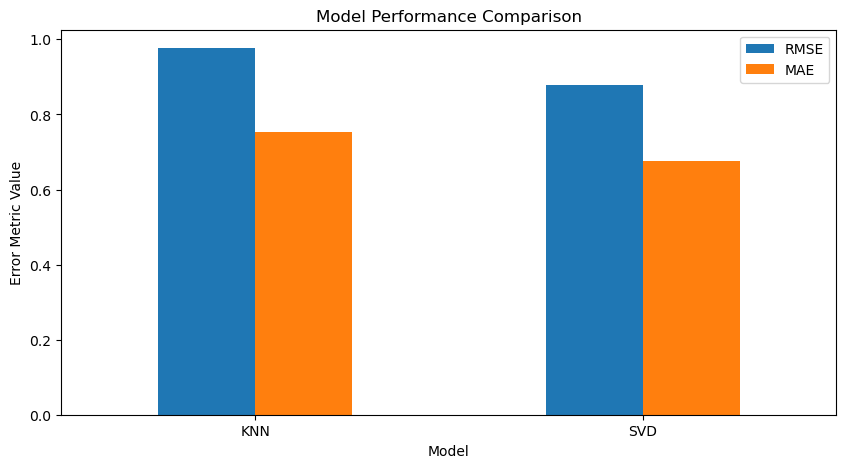


Model Performance Metrics:
  Model      RMSE       MAE   CV RMSE    CV MAE
0   KNN  0.976835  0.752375  0.980084  0.755402
1   SVD  0.879200  0.676498  0.881807  0.678152


In [11]:
# Visualize model performance
metrics_df.set_index('Model')[['RMSE', 'MAE']].plot(kind='bar', figsize=(10,5))
plt.title('Model Performance Comparison')
plt.ylabel('Error Metric Value')
plt.xticks(rotation=0)
plt.show()

print("\nModel Performance Metrics:")
print(metrics_df)

In [12]:
# Collaborative Recommendations for User 1 using SVD
user_id = 1
top_n = 5

# Get all movies the user hasn't rated
rated_movies = ratings[ratings['userId'] == user_id]['movieId']
all_movies = ratings['movieId'].unique()
unseen_movies = [m for m in all_movies if m not in rated_movies.values]

# Predict ratings for unseen movies
svd_testset = [[user_id, movie_id, 4.] for movie_id in unseen_movies]
predictions = svd.test(svd_testset)

# Get top predictions
top_movies = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n]
recommended_movie_ids = [int(pred.iid) for pred in top_movies]

# Display recommended movie titles
collab_recs = movies[movies['movieId'].isin(recommended_movie_ids)][['title', 'genres']].copy()
collab_recs['predicted_rating'] = [pred.est for pred in top_movies]

print("\nCollaborative recommendations for user 1:")
print(collab_recs.sort_values('predicted_rating', ascending=False))


Collaborative recommendations for user 1:
                                                  title  \
277                    Shawshank Redemption, The (1994)   
585   Wallace & Gromit: The Best of Aardman Animatio...   
680                      Philadelphia Story, The (1940)   
971                                       Patton (1970)   
6315                               Departed, The (2006)   

                              genres  predicted_rating  
277                   [Crime, Drama]                 5  
585   [Adventure, Animation, Comedy]                 5  
680         [Comedy, Drama, Romance]                 5  
971                     [Drama, War]                 5  
6315        [Crime, Drama, Thriller]                 5  


In [13]:
# Hybrid Recommendations for User 1 who liked "Toy Story"
query = "Toy Story"
user_id = 1
top_n = 5

# Content-based scores
try:
    query_idx = movies[movies['title'].str.contains(query, case=False)].index[0]
    content_scores = title_similarity[query_idx]
except IndexError:
    print("Movie not found")

In [14]:
# Collaborative filtering predictions
svd_scores = []
for movie_id in movies['movieId']:
    svd_scores.append(svd.predict(user_id, movie_id).est)

# Normalize scores
content_scores_norm = (content_scores - np.min(content_scores)) / (np.max(content_scores) - np.min(content_scores))
svd_scores_norm = (np.array(svd_scores) - np.min(svd_scores)) / (np.max(svd_scores) - np.min(svd_scores))

# Combine scores (equal weight)
combined_scores = 0.5 * content_scores_norm + 0.5 * svd_scores_norm

# Get top recommendations
top_indices = np.argsort(combined_scores)[::-1][:top_n]
hybrid_recs = movies.iloc[top_indices][['title', 'genres']].copy()
hybrid_recs['content_score'] = content_scores_norm[top_indices]
hybrid_recs['collab_score'] = svd_scores_norm[top_indices]
hybrid_recs['combined_score'] = combined_scores[top_indices]

print("\nHybrid recommendations for user 1 who liked 'Toy Story':")
print(hybrid_recs.sort_values('combined_score', ascending=False))



Hybrid recommendations for user 1 who liked 'Toy Story':
                               title  \
0                   Toy Story (1995)   
2355              Toy Story 2 (1999)   
7355              Toy Story 3 (2010)   
680   Philadelphia Story, The (1940)   
3595                 Toy, The (1982)   

                                                 genres  content_score  \
0     [Adventure, Animation, Children, Comedy, Fantasy]       1.000000   
2355  [Adventure, Animation, Children, Comedy, Fantasy]       0.829901   
7355  [Adventure, Animation, Children, Comedy, Fanta...       0.828108   
680                            [Comedy, Drama, Romance]       0.237540   
3595                                           [Comedy]       0.619902   

      collab_score  combined_score  
0         0.793631        0.896816  
2355      0.855445        0.842673  
7355      0.789570        0.808839  
680       1.000000        0.618770  
3595      0.617516        0.618709  


In [15]:
# Cold Start Handling - Popular Recommendations
avg_ratings = ratings.groupby('movieId')['rating'].mean()
rating_counts = ratings.groupby('movieId')['rating'].count()
popular_movies = pd.DataFrame({
    'avg_rating': avg_ratings,
    'rating_count': rating_counts
}).sort_values(['rating_count', 'avg_rating'], ascending=False)

popular_recs = pd.merge(
    popular_movies.head(top_n),
    movies,
    left_index=True,
    right_on='movieId'
)[['title', 'genres', 'avg_rating', 'rating_count']]

print("\nPopular Recommendations (Cold Start Fallback):")
print(popular_recs)


Popular Recommendations (Cold Start Fallback):
                                 title                            genres  \
314                Forrest Gump (1994)     [Comedy, Drama, Romance, War]   
277   Shawshank Redemption, The (1994)                    [Crime, Drama]   
257                Pulp Fiction (1994)  [Comedy, Crime, Drama, Thriller]   
510   Silence of the Lambs, The (1991)         [Crime, Horror, Thriller]   
1939                Matrix, The (1999)        [Action, Sci-Fi, Thriller]   

      avg_rating  rating_count  
314     4.164134           329  
277     4.429022           317  
257     4.197068           307  
510     4.161290           279  
1939    4.192446           278  


In [16]:
# Demonstration of different recommendation scenarios
print("\n--- DEMONSTRATION OF DIFFERENT APPROACHES ---")

# Content based
print("\n1. Content-based recommendations for 'Inception':")
try:
    inception_idx = movies[movies['title'].str.contains("Inception", case=False)].index[0]
    sim_scores = list(enumerate(title_similarity[inception_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:6]]
    print(movies.iloc[sim_indices][['title', 'genres']])
except IndexError:
    print("Movie not found in database")

# Collaborative
print("\n2. Collaborative recommendations for user 5:")
user_id = 5
rated_movies = ratings[ratings['userId'] == user_id]['movieId']
unseen_movies = [m for m in all_movies if m not in rated_movies.values]
svd_testset = [[user_id, movie_id, 4.] for movie_id in unseen_movies]
predictions = svd.test(svd_testset)
top_movies = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n]
recommended_movie_ids = [int(pred.iid) for pred in top_movies]
print(movies[movies['movieId'].isin(recommended_movie_ids)][['title', 'genres']])

# Hybrid
print("\n3. Hybrid recommendations for user 10 who liked 'The Dark Knight':")
user_id = 10
query = "The Dark Knight"
try:
    query_idx = movies[movies['title'].str.contains(query, case=False)].index[0]
    content_scores = title_similarity[query_idx]
    svd_scores = []
    for movie_id in movies['movieId']:
        svd_scores.append(svd.predict(user_id, movie_id).est)
    content_scores_norm = (content_scores - np.min(content_scores)) / (np.max(content_scores) - np.min(content_scores))
    svd_scores_norm = (np.array(svd_scores) - np.min(svd_scores)) / (np.max(svd_scores) - np.min(svd_scores))
    combined_scores = 0.5 * content_scores_norm + 0.5 * svd_scores_norm
    top_indices = np.argsort(combined_scores)[::-1][:top_n]
    print(movies.iloc[top_indices][['title', 'genres']])
except IndexError:
    print("Movie not found in database")

# Cold start handling
print("\n4. Cold start handling for new user (showing popular movies):")
print(popular_recs)


--- DEMONSTRATION OF DIFFERENT APPROACHES ---

1. Content-based recommendations for 'Inception':
                      title            genres
7343     Please Give (2010)   [Comedy, Drama]
7419  I'm Still Here (2010)   [Comedy, Drama]
7431       You Again (2010)          [Comedy]
7450       Hereafter (2010)  [Drama, Fantasy]
7462       Somewhere (2010)           [Drama]

2. Collaborative recommendations for user 5:
                                       title  \
863   Monty Python and the Holy Grail (1975)   
922           Godfather: Part II, The (1974)   
975                    Cool Hand Luke (1967)   
1218                L.A. Confidential (1997)   
2372                  Green Mile, The (1999)   

                                     genres  
863            [Adventure, Comedy, Fantasy]  
922                          [Crime, Drama]  
975                                 [Drama]  
1218  [Crime, Film-Noir, Mystery, Thriller]  
2372                         [Crime, Drama]  

3. Hybrid reco